Nisheeth 

---------------------------------------


1. [Overview](#overview)

    1.1 [Import Libraries](#import)
    
    1.2 [Load data sets](#load)
    
    1.3 [Visualize trips in new York city map](#newYorkMap)
    
    1.4 [Explore data](#explore)
    
   
2. [Analyzing Categorical and numerical variables](#variables)

    2.1 [Univariate Analysis](#variables)

    2.2 [Multivariate Analysis](#multivari)


3. [Feature Engineering](#datetime)

    3.1 [Date time Features](#datetime)
    
    3.2 [distance and Speed](#distspeed)
    
    
4. [Model and Prediction](#model)
    
    4.1 [Random Forest](#rf)

<a id='overview'></a>


<a id='overview'></a>

## Prologue

*We are already late for the party, Hurry up let's catch the last cab left to Manhattan!*
Here, the challenge is to predict journey time of taxi trips in New York city, based on features like pickup time stamp and ride start and destination co-ordinates(longitude and latitude).

## What Are We Going To Analyze?

Let's define a structure  for our analysis
1. Variables - 
    Analyze Independent Variables first and later find out how they correlate with dependent variable.
    
2. Type of Variables - 
    * Study Categorical Vs Numerical, 
      - Categorical variable means whose values can be grouped into categories like 1 or 2, high/medium/low, True/False
      - Numerical variable  means whose values are integers or floats.
    
3. Segments -
    * Study of Temporal Vs Spatial variables
    
       - Temporal features means time series data whose values are recorded in order of time eg Dates, months , hours
       - Spatial features means geographical data i.e locations, latitude/longitude coordinates

4. Temporal Features Analysis:
    * Seasonality -
         Do number of taxi trips increase in a particular calendar period?
         For example, during public holidays, festivals, or specific business quarters?

    * Trends -  
        On average, does the number of trips increase or decrease over time?
      
    * Cyclic Movements - 
        Is there a long-run cycle or period unrelated to seasonality factors?

5. Spatial Features Analysis
    * Clustering- Group locations in data which generally take longer/shorter journey time?

    * Distance -
        Calculate distance between pickup and dropoff locations.
       
    * Speed -
        Calculate speed of the taxi ride.

6. Data Inconsistency:
    * Gaps - Are there any missing values in data?

    * Outliers - Do they exist? Outliers may affect conclusions strongly, and can be misleading.

7. Conclusion: Conclusion for each type of analysis/variables

*Let's consider this analogy of friends going to pub for partying in Manhattan in an Black and Yellow Taxi.
On the way we have to pickup lot of friends and drop them back home*

Hang tight! Lets start the fun ride.
<a id='import'></a>
### Import Libraries

In [1]:
#Let's check the preps, food check Beer check venue check!!
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *

from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral4

import folium 
from folium import plugins
from folium.plugins import HeatMap

output_notebook()

Loading BokehJS ...

<a id='load'></a>
### Load Data sets

In [2]:
!unzip ../input/nyc-taxi-trip-duration/train.zip
!unzip ../input/nyc-taxi-trip-duration/test.zip

Archive:  ../input/nyc-taxi-trip-duration/train.zip
  inflating: train.csv               
Archive:  ../input/nyc-taxi-trip-duration/test.zip
  inflating: test.csv                


In [3]:
!ls 

__notebook_source__.ipynb  test.csv  train.csv


In [4]:
#bring in the 6 packs
train=pd.read_csv("train.csv")#../input/nyc-taxi-trip-duration/
train.head(3)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [5]:
#Verify assumptions and loopholes in our analysis
test=pd.read_csv("test.csv")#../input/nyc-taxi-trip-duration/
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


<a id='newYorkMap'></a>
## Let's have a breathtaking view of New York City with Animated HeatMap :)

*First things first! Set theme!* Let's plot beautiful New York city where we are going to go with the help of our pickup and dropoff coordinates.

We will plot monthwise (timeseries) drop off locations using HeatMap.

We will use Folium library for this, which is python wrapper for R package Leaflet .

There are some latitude and longitude co-ordinates which are way far from New York city. Let's filtered them out.

In [6]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [7]:
#Extract the month column from pickup datetime variable and take subset of data
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_month'] = train['dropoff_datetime'].dt.month

heat_df =train.sample(n=2500)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_month']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)


#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
heat_df['Weight'] = heat_df['dropoff_month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'Weight'])

In [8]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
                 for i in range(0,6)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

# Display the map
newyork_on_heatmap

1. If you hover at left side bottom buttons 2nd and  rd button which says play and play reverse. If you press them you can see animations. (auto-play is enabled, in case it doesn't work)
2. These are the drop off location all over new york. Isn't it visual treat? Wow !!
3. The heat points are drop off co-ordiantes, which are getting displayed monthwise from January to June at every time step.

Let's take static view using BaseMap.

## Pickups and Dropoff locations
Let's now separately look at pickups and dropoffs to understand where all we have to pick our friends and bid them goodbye after party gets over.

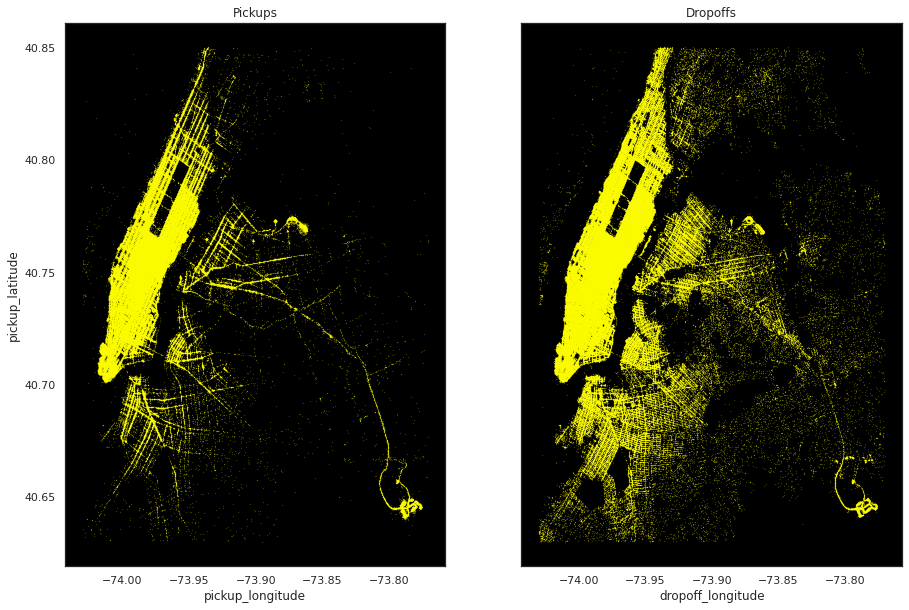

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

*Wow looks magnificent! The place where we are going for party already blooming with flashlights.*

As we can see in the above map ,
1. Most of journeys have been to or from Manhattan, as Manhattan looks well-lit area in the map.
2. Other locations where I can see traffic(bright lights in map) is at 2 airports, John F. Kennedy and LA Guardia Airport in Queens.
3. Most of the pickups are from Manhattan and mainly north of central park probably to the workplaces(Business Areas) or may be to pubs who knows folks might be chilling out like us ;). 
4. Dropoffs are scattered all over New York city. May be people taking cabs to their homes.
5. The 2 airports in Queens seems busy with both to and from journeys.


## Trips from LA Guardia Airport Animation

Let's View another cool animation of pickup and dropoffs of trips using Folium **Timestamped GeoJSON** plugin.
We have filtered to and fro trips from LA Guardia International Airport.

Get Ready for another supercool map guyz.!


In [10]:
#co-ordinates
LaGuardia = {
    "minLat": 40.76,
    "maxLat": 40.78,
    "minLong": -73.895,
    "maxLong": -73.855
}
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

LaGuardiaData = train[(train['pickup_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['pickup_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]
LaGuardiaData = train[(train['dropoff_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['dropoff_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]

m = folium.Map(
    location=[40.7769, -73.8740],
    zoom_start=12
)
folium.Marker(location=[40.7769, -73.8740],icon=folium.Icon(color='black') ,popup='LA Guardia International Airport').add_to(m)

shortTripsDF=LaGuardiaData[LaGuardiaData.trip_duration==900]

lines = [
    {
        'coordinates': [
            [shortTripsDF.pickup_longitude.iloc[index], shortTripsDF.pickup_latitude.iloc[index]],
            [shortTripsDF.dropoff_longitude.iloc[index], shortTripsDF.dropoff_latitude.iloc[index]],
        ],
        'dates': [
        str(shortTripsDF.pickup_datetime.iloc[index]),
        str(shortTripsDF.dropoff_datetime.iloc[index])
        ],
        'color': 'gold'
    }
    for index in range(100)
]
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 10
            }
        }
    }
    for line in lines
]


plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT24H', add_last_point=True).add_to(m)
m

If you look at above map, 
1. yellow lines mark the trip distance.
2. Trip starts at pickup location , start of yellow color line and stops where the blue marker gets created. 
3. Black Marker denotes exact location of LA Guardia International Airport. If you click on black marker ,its location name popups. 
4. Most of the trips to airport are to or from Manhattan.
Hope you loved it :)

<a id='explore'></a>

### Explore Data
*Ohh wait! Do we have guest list ready?*
Below are the names and characteristics of friends we have to pick on the way:


| Variable name       | Variable description|
|---------------------|-------------------------------------|
| id                  | A unique identifier for each trip   |
| vendor_id           | A code indicating the provider associated with the trip record|
| pickup_datetime     | Date and time when the meter was engaged |
| dropoff_datetime    | Date and time when the meter was disengaged |
| passenger_count     | The number of passengers in the vehicle (driver entered value)|
| pickup_longitude    | The longitude where the meter was engaged|                                                
| pickup_latitude     | The latitude where the meter was engaged|                                                 
| dropoff_longitude   | The longitude where the meter was disengaged|
| dropoff_latitude    | The latitude where the meter was disengaged|
| store_and_fwd_flag  | whether the trip record was held in vehicle memory before sending to the vendor|
| trip_duration       | Duration of the trip in seconds          |                                                                                                                                                                     
***Take the headcounts!!***

Let's visualize how many observations and columns are there in the `train` and `test` data sets.

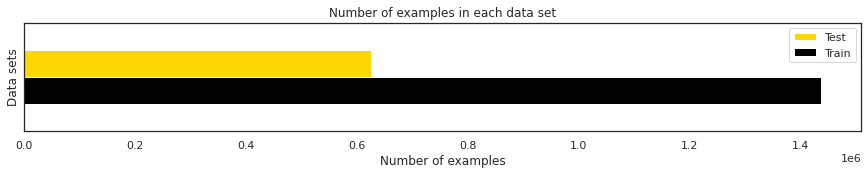

In [11]:
pd.DataFrame({'Train': [train.shape[0]], 'Test': [test.shape[0]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of examples in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of examples");

In [12]:
print("Training headcount is %i." % train.shape[0])
print("Testing headcount is %i." % test.shape[0])

Training headcount is 1438626.
Testing headcount is 625134.


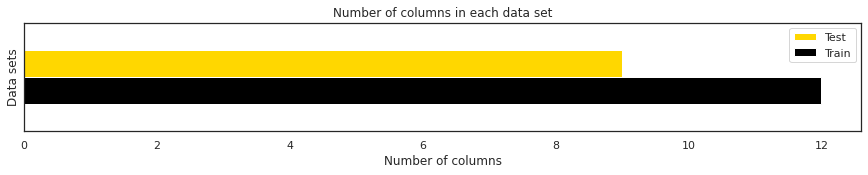

In [13]:
pd.DataFrame({'Train': [train.shape[1]], 'Test': [test.shape[1]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of columns in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of columns");

There are 11 columns in train and 9 in test as trip duration and dropoff datetime is not there in test.
Thanks to [Tuomas Tikkanen](https://www.kaggle.com/tuomastik) for color code idea.

### Describing the data

In [14]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dropoff_month
count,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,945.99,3.52
std,0.50,1.31,0.04,0.03,0.03,0.03,5252.16,1.68
min,1.00,0.00,-74.03,40.63,-74.03,40.63,1.00,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00,2.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,656.00,4.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1059.00,5.00
max,2.00,6.00,-73.77,40.85,-73.77,40.85,3526282.00,7.00


1. Looking at count of all columns, we can conclude we have have no missing values.
  *Yehh all our friends have already RSVP'ed for the party*
2. Another thing to note is minimum Passenger count is 0 , that's clearly an outlier may be taxi driver wants some free money from vendor :P.  We need to remove that. Maximum Passenger group is 6 that's fine.
3. Also note minimum trip duration is 1 second, those trips are going nowhere and maximum is 35,26,282 seconds. Ohh my my!!! that's total of 979.5 hours.  Nobody travels that long in taxi. 
    
    Outliers found!! Needs to be removed.
    
Let's verify test set.

In [15]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.00,625134.00,625134.00,625134.00,625134.00,625134.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75
std,0.50,1.31,0.07,0.03,0.07,0.04
min,1.00,0.00,-121.93,37.39,-121.93,36.60
25%,1.00,1.00,-73.99,40.74,-73.99,40.74
50%,2.00,1.00,-73.98,40.75,-73.98,40.75
75%,2.00,2.00,-73.97,40.77,-73.96,40.77
max,2.00,9.00,-69.25,42.81,-67.50,48.86



<a id='variables'></a>

Looking at count of all columns, we can conclude that we have no missing values.
*Thats cool! party is gonna be bang on!*

## Analyze variables
We will analyze individual features and their relations with target variable to find out how individual feature co relates with target variable. 
Also we will find out how important is single feature or it's transformation to predict target variable.

### Univariate Analysis
Analyzing single feature at a time is called as univariate analysis.

### What is the Trip duration?
Trip Duration is the best friend of ours who's throwing party.
Trip Duration is the reason for our pursuit (of happiness).

Trip duration: "Come, Poonam, we must prepare for tonight."

Poonam: "Why? What are we going to do tonight."

Trip duration: "Same thing we do every night, Poonam. Try to take over the world!"

Let's catch the last cab to New York!

We will plot trip duration of each taxi ride, target variable also called as dependent variable.

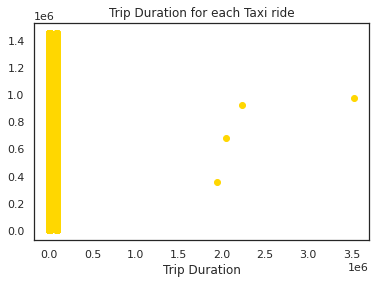

In [16]:
plt.scatter(train.trip_duration,train.index,color="gold")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

Looks like some trips are going too far away from New York city(*Long rides who knows*).
These are outliers.
Since the evaluation metrics is RMSLE(Root Mean Squared Logarithmic Error), we can log transform trip duration and use RMSE(Root Mean Squared Error) for training. So that outliers won't affect model performance much.
Don't forget to take exponential of it while submitting submission file.

In [17]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

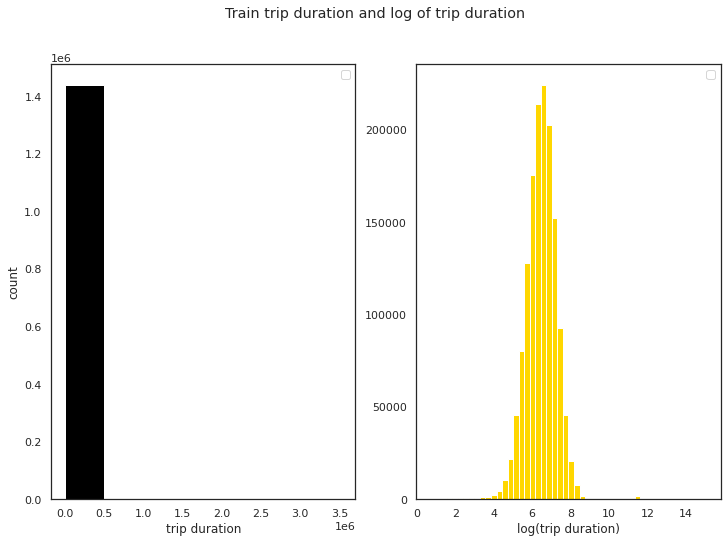

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train.trip_duration,color='black',bins=7)
ax2.hist(train.log_trip_duration,bins=50,color='gold');

In [19]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


## Categorical Features

*Let's pick up some more friends of Trip Duration.*

### Who is famous Vendor?
*Ok, who is better at night driving, anyone?*

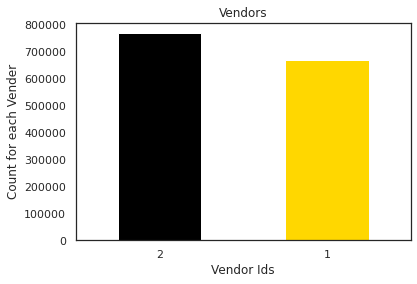

In [20]:
train["vendor_id"].value_counts().plot(kind='bar',color=["black","gold"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vender")
plt.xlabel("Vendor Ids");

Only 2 Vendors are there, they can be representing 2 taxi companies. Vendor 2 has more share in taxi rides in New York city.(Better drivers ;))

### How many passengers are traveling together?
*Wht's your buddy group size??*

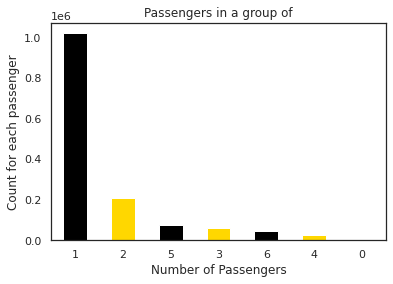

In [21]:
train["passenger_count"].value_counts().plot(kind='bar',color=["black","gold"])
plt.title("Passengers in a group of")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for each passenger")
plt.xlabel("Number of Passengers");

1. Most popular choice of travel is single.
2. 2nd popular way of ride is with a single friend.  
3. May be for long cars popular choice of travel is in group of 5 and then in group of 6 people.
4. There are only 3 trips in group of 7 and single trip in group of 8 and 9 each.
5. There are 60 trips with zero passengers. Those must be outliers and have to be removed. Because no taxi ride can happen without passenger, at least paid one.

### Whether the Trip Details are Stored Or Forwarded?
*Time for poses  and flashes, let's have selfies for facebook and whatsapp DPs.*

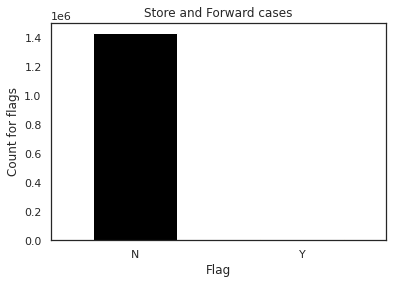

In [22]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar',color=["black","gold"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag");

Almost all the journey details were immediately sent to vendors. Very few stored in device memory may be due to bad signal or bad weather.

<a id='datetime'></a>
## Feature Engineering 

### How about Dates and timings of the trips?  - *our temporal friends*

We can extract lot of insights from dates and time data we have.
1. Pickup hour rushes can define start of office timings and drop offs in evening can tell till what time New Yorkers work. 
2. Weekdays and weekends can show another angle of city life. Weekends people will be getting up late and starting day late compared to weekdays. Also parties can go beyond midnight hours on weekends.
3. We can also look out for some kind of seasonality. 
    For example, during winter seasons traffic will be going slow due to snowfalls or wetness on Roads. So, trip Duration will be longer in winters than other seasons.

In [23]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)


for df in (train,test):
    # Dates
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    #month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month

    #weekday 0 to 6
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday


    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #minute of hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute

    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']


test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## Seasonality

>"To everything there is a season, a time for every purpose under the sun.” 

A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period. Hence, seasonal time series are sometimes called periodic time series.

Let's find out seasonal patterns in our data.

## Taxi trips By Months

Lets plot trip durations for each month. Which one is favourite party month for you guyz? Mine is May ;)

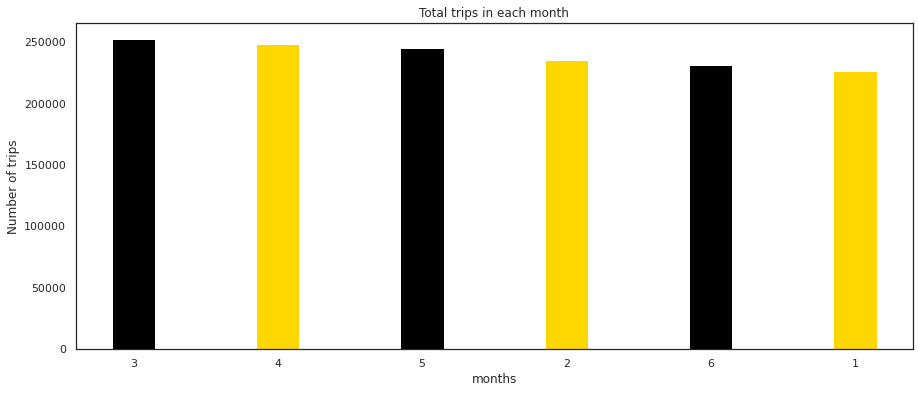

In [24]:
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");

We have data from January to June of 2016. Highest number of trips happened in March and lowest in January.

### Month and Trip Durations Together with Vendor Contribution
Since we have kernel memory limit , I have taken subset of data

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 44.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 45.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/pyth

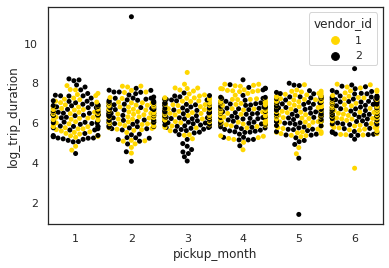

In [25]:
sns.swarmplot(train.pickup_month[:1000],train.log_trip_duration[:1000],hue=train.vendor_id[:1000],palette={1:'gold',2:'black'});

There is nothing dishtinguishable here, few outliers here and there. Vendors contribution is apporoximately same.
There is linear relationship between Month and Trip Duration.

### Taxi Trips By Pickup Dates

In [26]:
tripsByDate=train['pickup_date'].value_counts()

# Basic plot setup
plot = figure( x_axis_type="datetime", tools="",
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Taxi trip counts', title='Hover over points to see taxi trips')

x,y= tripsByDate.index, tripsByDate.values
plot.line(x,y, line_dash="4 4", line_width=1, color='gold')

cr = plot.circle(x, y, size=20,
                fill_color="gold", hover_fill_color="black",
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color="black")
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)

If you hover on the lines of above plot you can see all taxi rides that took place in those particular dates.
Lowest spike is around end of January. Yes you guessed it right. Its due to [heavy snowfall](https://tinyurl.com/jtecbrd) happened in New York on 23rd and 24th January.
April and March were busy months recorded with highest number of pickups.

In [27]:
print("Highest number of pickups  i.e", tripsByDate[0] , "happened on", str(tripsByDate.index[0]))
print("And lowest number of pickups  i.e", tripsByDate[tripsByDate.size-1] , "happened on",
      str(tripsByDate.index[tripsByDate.size-1]), "due to heavy snowfall in New York.")

Highest number of pickups  i.e 9681 happened on 2016-04-09
And lowest number of pickups  i.e 1624 happened on 2016-01-23 due to heavy snowfall in New York.


## Dashing through the snow
Let's plot which of our friends are travelling in the snowfall and where?

In [28]:
snowFallDF=train[(train['pickup_dayofyear'] == 24) |  (train['pickup_dayofyear'].any() == 23)]
snowFallDF.shape

(3337, 23)

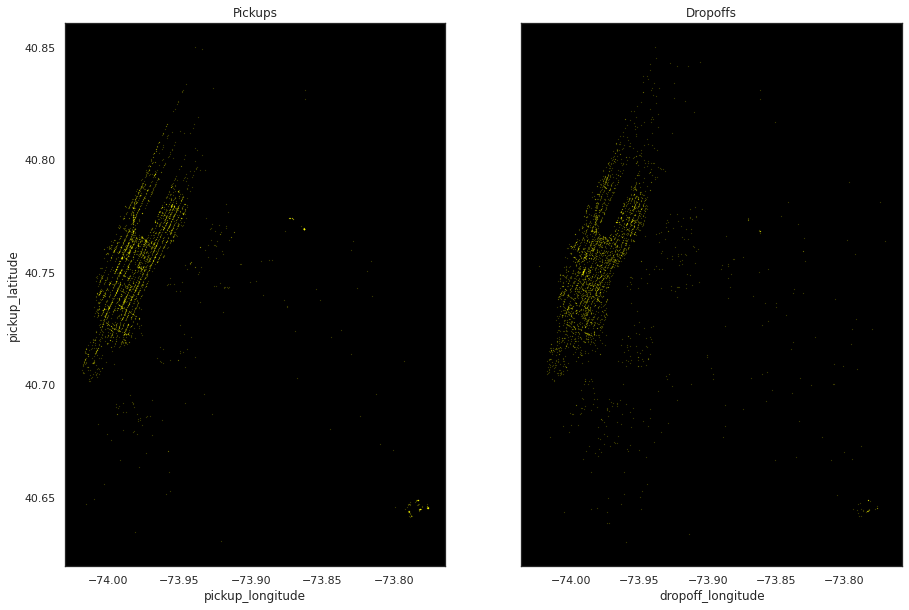

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

snowFallDF.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

snowFallDF.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

Looks like very less trips have happened due to heavy snowfall. Hope travellers were safe!
While doing feature engineering we will get help of external weather dataset,which has snowfall information in New York.

### Taxi Trips By Dropoff Date

In [30]:
train['dropoff_date'] = train['dropoff_datetime'].dt.date
tripsByDropoffDate=train['dropoff_date'].value_counts()

# Basic plot setup
plot = figure( x_axis_type="datetime", tools="",
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Taxi trip counts', title='Hover over points to see taxi trips')

x,y= tripsByDropoffDate.index, tripsByDropoffDate.values
plot.line(x,y, line_dash="4 4", line_width=1, color='gold')

cr = plot.circle(x, y, size=20,
                fill_color="gold", hover_fill_color="black",
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color="black")
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)
train.drop('dropoff_date',axis=1,inplace=True)

If you hover on the lines of above plot you can see all taxi rides that happened in those particular dates.
Lowest spike is around end of June i.e 1st of July. We have 1 extra day dropoff data in training dataset and March were busy months recorded with highest number of pickups.

In [31]:
print("Highest number of dropoffs  i.e", tripsByDropoffDate[0] , "happened on", str(tripsByDropoffDate.index[1]))
print("And lowest number of dropoffs  i.e", tripsByDropoffDate[tripsByDropoffDate.size-1] , "happened on",
      str(tripsByDropoffDate.index[tripsByDropoffDate.size-1]))

Highest number of dropoffs  i.e 9681 happened on 2016-03-05
And lowest number of dropoffs  i.e 123 happened on 2016-07-01


### Taxi Trips By Pickup Day of the Month

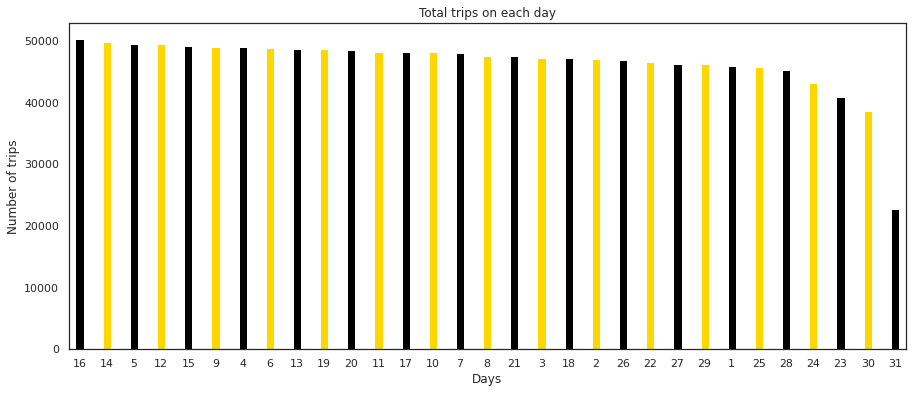

In [32]:
plt.figure(figsize=(15, 6)) 
train.pickup_day.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Days")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each day");

1. Highest number of trips happened on 16th of the month while lowest on 31st. 
2. 30th and 31st have less trips because we have 6 months data and 30th and 31st came only 3 times each.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


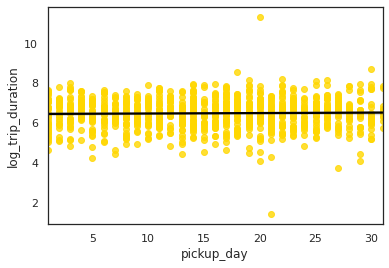

In [33]:
sns.regplot(train.pickup_day[:1000],train.log_trip_duration[:1000],color='gold', line_kws={'color':'black'});

The median of trip duration is approximately 6.48. There is clearly linear relationship between these two. Hmm!!
The solid black line depicts linear regression model fit.

### Taxi Trips By Pickup WeekDays

0: Monday - 1: Tuesday - 2: Wednesday - 3: Thursday - 4: Friday - 5: Saturday - 6: Sunday


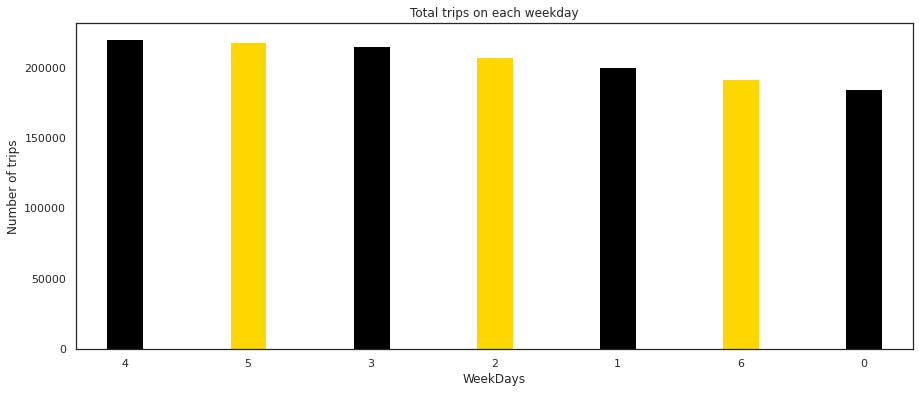

In [36]:
train['pickup_weekday_name'] = train['pickup_datetime'].dt.weekday
plt.figure(figsize=(15, 6)) 
train.pickup_weekday_name.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("WeekDays")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each weekday");
train.drop('pickup_weekday_name',axis=1,inplace=True)
print("0: Monday - 1: Tuesday - 2: Wednesday - 3: Thursday - 4: Friday - 5: Saturday - 6: Sunday")

Highest number of trips took place on every Friday of the week while lowest on Mondays. (Monday blues :()
Thursday and Saturday were also busy days.

### Taxi Trips By Pickup Hour

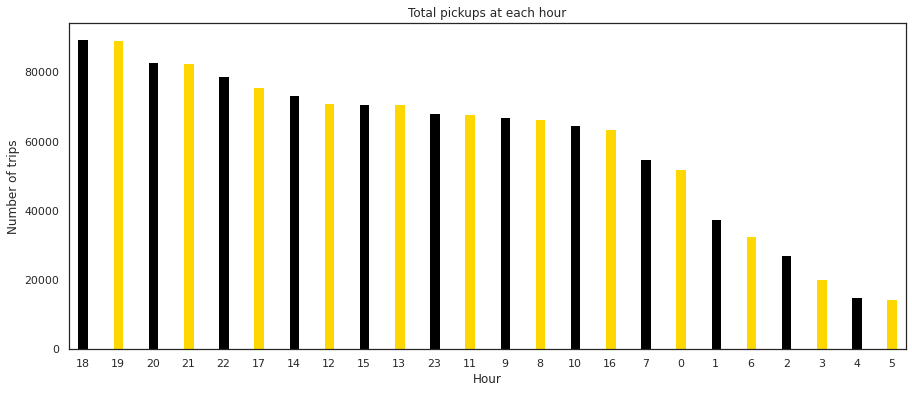

In [37]:
plt.figure(figsize=(15, 6)) 
train.pickup_hour.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Hour")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total pickups at each hour");

Most pickups were at 6 O'Clock in the evening may be due to people are leaving from work and least at 5 O'Clock early morning. Demand for pick ups starts from 6 in the early morning and it keeps growing as day passes.

### Taxi trips by pickup hour and trip duration

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


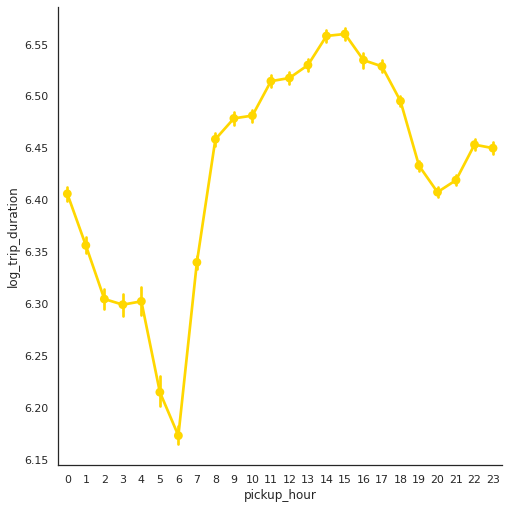

In [38]:
sns.factorplot(x="pickup_hour", y="log_trip_duration", data=train,color='gold',size=7);

Wohoo.  This is **seasonal**. 

1. Lowest trip durations were in early mornings past midnight. May be people don't want to walk in dark./Or may be they are drunk ;) Don't Drink and Drive!!
2. Traffic starts increasing once its 8AM people starting to offices and reaches it's peak around 3 O'Clock in noon.
3. And then starts decreasing slowly and again peaks after 8 till  late nigh 11 O'Clock. May be because people going home after work hours.

### Taxi Trips By Dropoff Hour

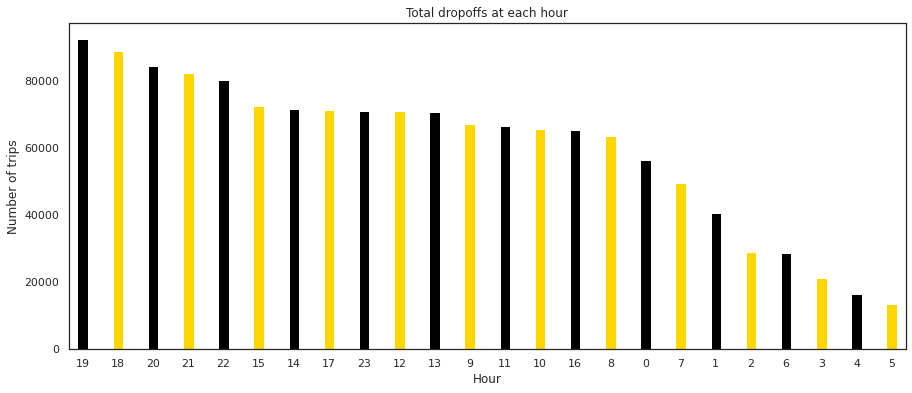

In [39]:
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
plt.figure(figsize=(15, 6)) 
train.dropoff_hour.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("Total dropoffs at each hour");
train.drop('dropoff_hour',axis=1,inplace=True)

Most dropoffs were at 19 i.e 7 O'Clock in the evening due to people are leaving from work and reaching home.
Least at 5 O'Clock early morning.
Demand for dropoffs may be to office starts growing from around 9 )'clock and it keeps on increasing as Day passes.
New Yorkers tend to work late as dropoffs are going on till 12 O'Clock at midnight and slowly reduce after that. 

## Taxi trips by pickup minute Vs. Trip Duration

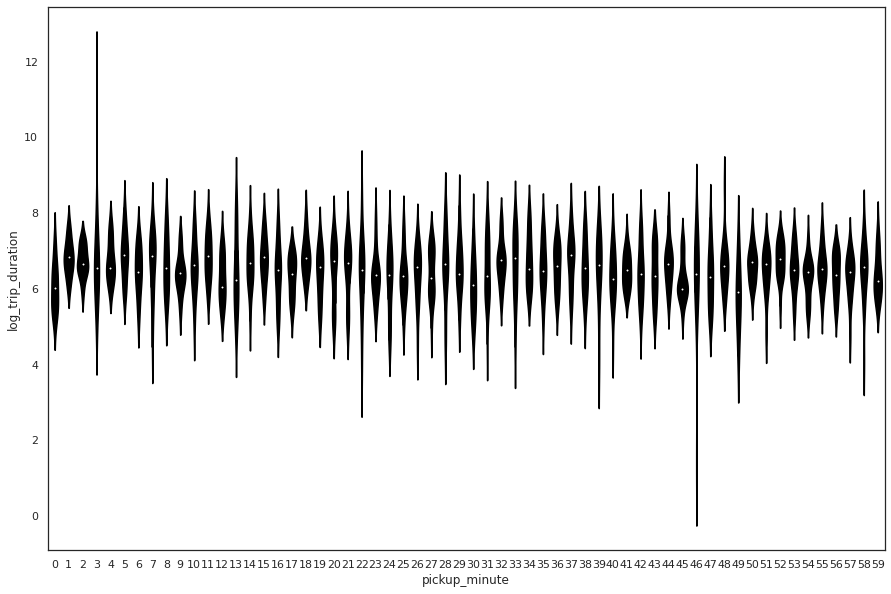

In [40]:
fig=plt.figure(figsize=(15,10))
sns.violinplot(x="pickup_minute", y="log_trip_duration", data=train[:1000],color='black');

There are large spikes at minute 4 and 47.
Pickup minute is also very important since we have to calculate total duration in seconds.
Linear relationship can be seen in these 2 as well. :)

### Store or Forward Flag
Let's convert this to numeric.

In [41]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

### Longitude and Latitude coordinates - *our Spatial friends*
Most of the information lies here.
We have explored them thoroughly in the initial animated plots itself. Let' s plot a histogram now to understand its distribution.

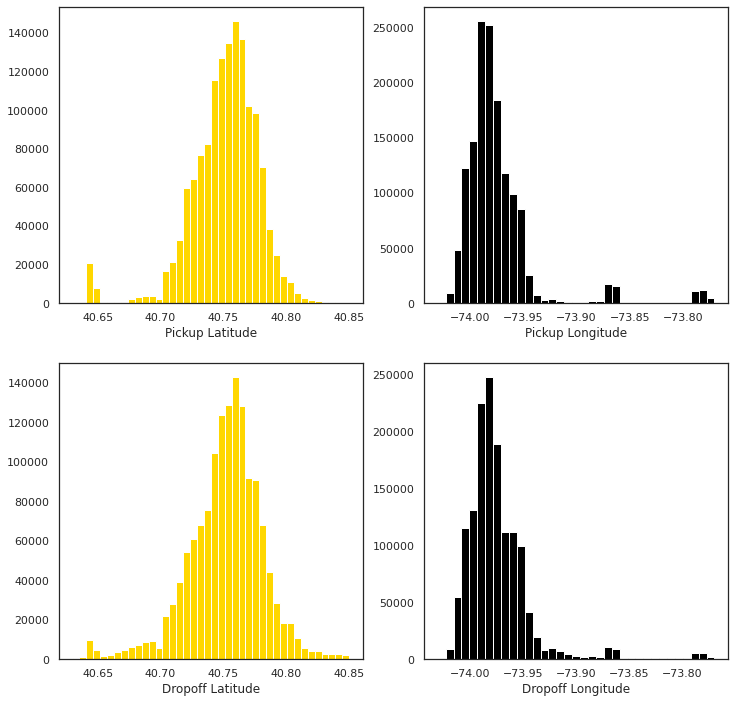

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12, 12), sharex=False, sharey = False)
ax[0,0].hist(train.pickup_latitude.values,bins=40,color="gold")
ax[0,1].hist(train.pickup_longitude.values,bins=35,color="black")
ax[1,0].hist(train.dropoff_latitude.values,bins=40,color="gold")
ax[1,1].hist(train.dropoff_longitude.values,bins=35,color="black")
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,1].set_xlabel('Pickup Longitude')
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,1].set_xlabel('Dropoff Longitude');

## Let's Calculate Distance and Speed of the trips


In [43]:
train=train[:100000]
test=test[:100000]

train['lat_diff'] = train['pickup_latitude'] - train['dropoff_latitude']
test['lat_diff'] = test['pickup_latitude'] - test['dropoff_latitude']

train['lon_diff'] = train['pickup_longitude'] - train['dropoff_longitude']
test['lon_diff'] = test['pickup_longitude'] - test['dropoff_longitude']

In [44]:
train['haversine_distance'] = train.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['haversine_distance'] = test.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_haversine_distance'] = np.log1p(train['haversine_distance']) 
test['log_haversine_distance'] = np.log1p(test['haversine_distance']) 

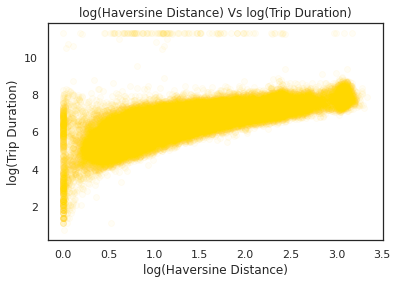

In [45]:
plt.scatter(train.log_haversine_distance,train.log_trip_duration,color="gold",alpha=0.04)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Haversine Distance)")
plt.title("log(Haversine Distance) Vs log(Trip Duration)");

As we can see in the graph above, trip distance defines lower boundry for trip duration.
Let's calculate manhattan distance as well, since we are in Manhattan.

In [46]:
def manhattan_distance(x,y):
  return sum(abs(a-b) for a,b in zip(x,y))

def euclidean_distance(x,y):
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

train['euclidean_distance'] = train.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['euclidean_distance'] = test.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_euclidean_distance'] = np.log1p(train['euclidean_distance']) 
test['log_euclidean_distance'] = np.log1p(test['euclidean_distance']) 

train['manhattan_distance'] = train.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
test['manhattan_distance'] = test.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['log_manhattan_distance'] = np.log1p(train['manhattan_distance']) 
test['log_manhattan_distance'] = np.log1p(test['manhattan_distance']) 

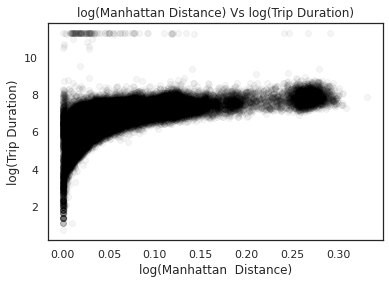

In [47]:
plt.scatter(train.log_manhattan_distance,train.log_trip_duration,color="black",alpha=0.04)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Manhattan  Distance)")
plt.title("log(Manhattan Distance) Vs log(Trip Duration)");

Trip distance specifies lower bound for journey time.

### Speed
Let's calculate speed now. Broom Broom!!

In [48]:
train.loc[:, 'avg_speed_h'] = 1000 * train['haversine_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['manhattan_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_eu'] = 1000 * train['euclidean_distance'] / train['trip_duration']

test.loc[:, 'avg_speed_h'] = 1000 * test['haversine_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = 1000 * test['manhattan_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_eu'] = 1000 * test['euclidean_distance'] / train['trip_duration']

### Speed in Hour and week 

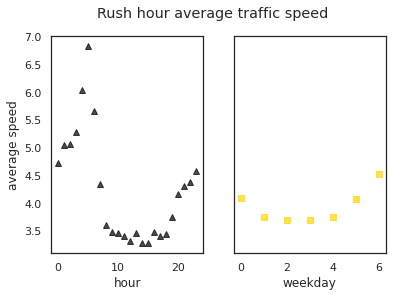

In [49]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], '^', lw=2, alpha=0.7,color='black')
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 's', lw=2, alpha=0.7,color='gold')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

###  Fastest Routes
Ok. Bring on google maps fastest routes!!

In [50]:
fastest_routes1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fastest_routes2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_fastest_routes = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_fastest_routes = pd.concat((fastest_routes1, fastest_routes2))
train = train.merge(train_fastest_routes, how='left', on='id')
test = test.merge(test_fastest_routes, how='left', on='id')


<a id='model'></a>

## Model and Predictions



In [51]:
target=train.log_trip_duration.values
train = train.drop(['id', 'pickup_datetime','dropoff_month', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_date'], axis=1)
train.fillna(0,inplace=True)
train.dtypes


vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int64
pickup_day                  int64
pickup_month                int64
pickup_weekday              int64
pickup_weekofyear           int64
pickup_hour                 int64
pickup_minute               int64
pickup_dayofyear            int64
pickup_dt                 float64
pickup_week_hour            int64
lat_diff                  float64
lon_diff                  float64
log_haversine_distance    float64
log_euclidean_distance    float64
log_manhattan_distance    float64
total_distance            float64
total_travel_time         float64
number_of_steps             int64
dtype: object

In [52]:
Id=test.id.values
test = test.drop(['id','pickup_datetime','pickup_date','haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu'], axis=1)
test.fillna(0,inplace=True)
predictors=test.columns
test.dtypes

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int64
pickup_day                  int64
pickup_month                int64
pickup_weekday              int64
pickup_weekofyear           int64
pickup_hour                 int64
pickup_minute               int64
pickup_dayofyear            int64
pickup_dt                 float64
pickup_week_hour            int64
lat_diff                  float64
lon_diff                  float64
log_haversine_distance    float64
log_euclidean_distance    float64
log_manhattan_distance    float64
total_distance            float64
total_travel_time         float64
number_of_steps             int64
dtype: object

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

### Fitting the model on train and predicting on test
I have taken subset of data due to kernel limitations.
You can try training on full dataset and predicting on complete test set to submit and check leaderboard score.

In [54]:
rf_model.fit(train.values, target)
predictions=rf_model.predict(test.values)
predictions[:5]

array([6.67844111, 6.28470066, 6.06059418, 6.92817161, 5.55084457])

### Submission

In [55]:
test['trip_duration'] = np.exp(predictions) - 1
test['id']=Id
test[['id', 'trip_duration']].to_csv('nisheeth.csv.gz', index=False, compression='gzip')
test['trip_duration'][:5]

0    794.08
1    535.30
2    427.63
3   1019.63
4    256.45
Name: trip_duration, dtype: float64

### Feature Importance

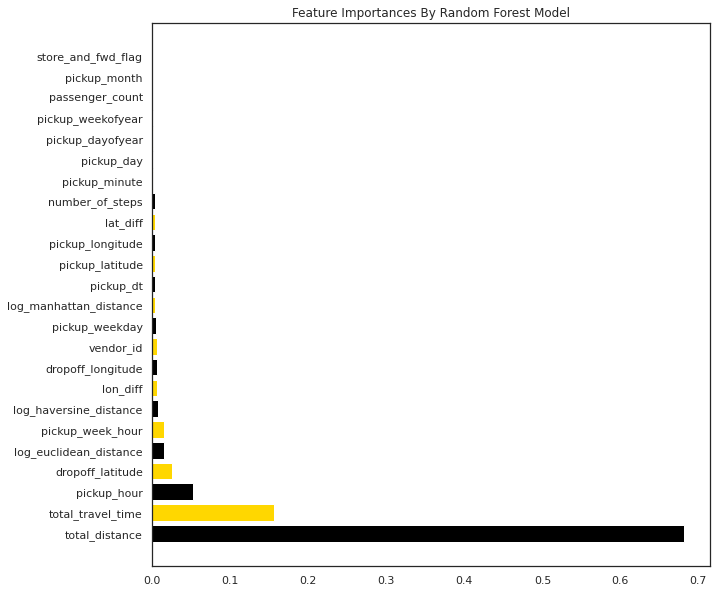

In [56]:
importances=rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

Thanks for reading. Hope you enjoyed.